# Data upload

In [7]:
import warnings
warnings.filterwarnings("ignore")

import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import gzip
import statsmodels.api as sm
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer

import sys
# Append to path the directory where the src folder is located
repo_path = '/root/ADA2023/ada-2023-project-adacadabra2023/ada-2023-project-adacadabra2023'
sys.path.append(repo_path)
import src.data.Preprocessing as pproc 
import src.data.HerdingFunctions as hf
import src.data.Text_preprocessing as txt_pproc

# 
directory = repo_path#os.getcwd()
data_path = os.path.join(directory, 'Data')

# Definining the path for the files
RB_path = os.path.join(data_path, 'RateBeer')
BA_path = os.path.join(data_path, 'BeerAdvocate')
MB_path = os.path.join(data_path, 'matched_beer_data')

# Extraction of the data and preprocessing of the files

In [2]:
# Extraction of the .tar files
pproc.extract_tar_files(data_path)

In [3]:
#Transformation of the .txt files
pproc.text_to_tsv(RB_path, 'ratings')
pproc.text_to_tsv(RB_path, 'reviews')

pproc.text_to_tsv(BA_path, 'ratings')
pproc.text_to_tsv(BA_path, 'reviews')

pproc.text_to_tsv(MB_path, 'ratings_ba')
pproc.text_to_tsv(MB_path, 'ratings_with_text_ba')
pproc.text_to_tsv(MB_path, 'ratings_rb')
pproc.text_to_tsv(MB_path, 'ratings_with_text_rb')

# Creation of dataframes

Matching data:

In [2]:
MB_beers = pd.read_csv(MB_path + '/beers.csv', header=1)
MB_breweries = pd.read_csv(MB_path + '/breweries.csv', header=1)
MB_users = pd.read_csv(MB_path + '/users.csv', header=1)
MB_users_approx = pd.read_csv(MB_path + '/users_approx.csv', header=1)

In [3]:
MB_ratings = pd.read_csv(MB_path + '/ratings.csv', header=1)
MB_ratingsBA = pd.read_csv(MB_path + '/ratings_ba.tsv', sep='\t')
MB_ratingsBA_txt = pd.read_csv(MB_path + '/ratings_with_text_ba.tsv', sep='\t')
MB_ratingsRB = pd.read_csv(MB_path + '/ratings_rb.tsv', sep='\t')
MB_ratingsRB_txt = pd.read_csv(MB_path + '/ratings_with_text_rb.tsv', sep='\t')

In [ ]:
RB_beers = pd.read_csv(RB_path + '/beers.csv')
RB_breweries = pd.read_csv(RB_path + '/breweries.csv')
RB_users = pd.read_csv(RB_path + '/users.csv')
RB_ratings = pd.read_csv(RB_path + '/ratings.tsv', sep='\t')
RB_reviews = pd.read_csv(RB_path + '/reviews.tsv', sep='\t')

In [ ]:
BA_beers = pd.read_csv(BA_path + '/beers.csv')
BA_breweries = pd.read_csv(BA_path + '/breweries.csv')
BA_users = pd.read_csv(BA_path + '/users.csv')
BA_ratings = pd.read_csv(BA_path + '/ratings.tsv', sep='\t')
BA_reviews = pd.read_csv(BA_path + '/reviews.tsv', sep='\t')

# Define filtration parameters:

Text(0.5, 0, 'Number of ratings (RB)')

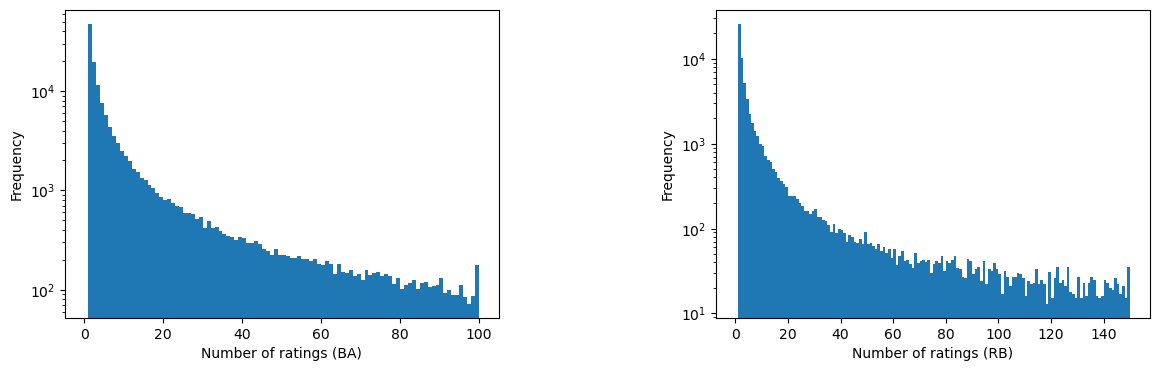

In [21]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(14,4), sharey=False, gridspec_kw={'width_ratios':[1,1], 'wspace': 0.5})

BA_users['nbr_ratings'].sort_values().plot(kind='hist', range = (0, 100), bins= 100, ax=axs[0], logy=True)
axs[0].set_xlabel('Number of ratings (BA)')
RB_users['nbr_ratings'].sort_values().plot(kind='hist', range = (0, 150), bins= 150, ax=axs[1], logy=True)
axs[1].set_xlabel('Number of ratings (RB)')

Text(0.5, 0, 'Number of ratings per beer (RB)')

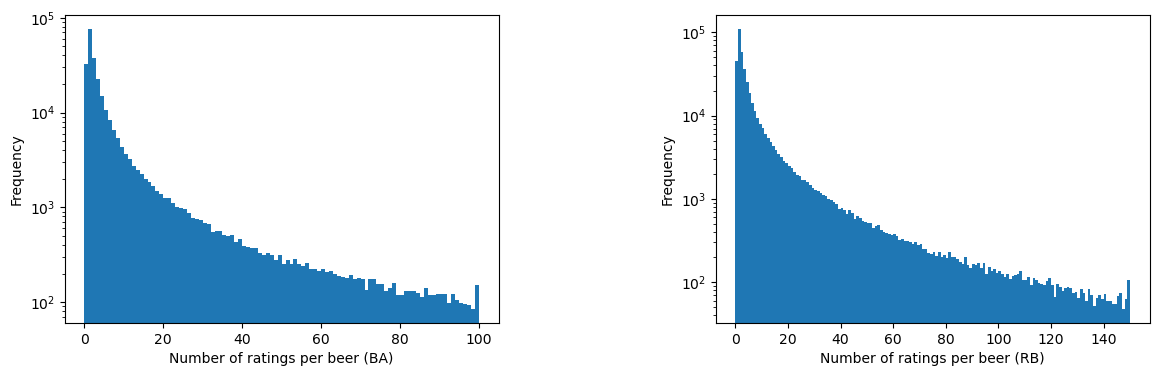

In [24]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(14,4), sharey=False, gridspec_kw={'width_ratios':[1,1], 'wspace': 0.5})

BA_beers['nbr_ratings'].sort_values().plot(kind='hist', range = (0, 100), bins= 100, ax=axs[0], logy=True)
axs[0].set_xlabel('Number of ratings per beer (BA)')
RB_beers['nbr_ratings'].sort_values().plot(kind='hist', range = (0, 150), bins= 150, ax=axs[1], logy=True)
axs[1].set_xlabel('Number of ratings per beer (RB)')

## Unification of dataframes

In [6]:
# Creation of the df with ALL the breweries with a unique brewery ID (chosen to be the one from RB)
unified_breweries = RB_breweries
unified_breweries = unified_breweries.rename(columns={'nbr_beers':'nbr_beers_rb'})

BA_brew = BA_breweries.add_suffix('_ba')

MB_breweries_subset = MB_breweries[['id', 'id.1', 'location', 'location.1', 'nbr_beers', 'nbr_beers.1', 'name', 'name.1']]
MB_breweries_subset = MB_breweries_subset.add_suffix('_ba')
MB_breweries_subset.columns = MB_breweries_subset.columns.str.replace('.1_ba' , '_rb')

merged_df = pd.merge(BA_brew, MB_breweries_subset, on=['id_ba', 'name_ba', 'location_ba', 'nbr_beers_ba'], how='left')
available_numbers_brew = np.setxor1d(np.arange(1,3*len(BA_brew)), unified_breweries.id.unique())
merged_df['new_ba_brew_id'] = available_numbers_brew[:len(BA_brew)]

merged_df['id'] = merged_df['id_rb'].combine_first(merged_df['new_ba_brew_id'])
merged_df['location'] = merged_df['location_rb'].combine_first(merged_df['location_ba'])
merged_df['name'] = merged_df['name_rb'].combine_first(merged_df['name_ba'])

unified_breweries = unified_breweries.merge(merged_df[['name', 'id', 'location', 'nbr_beers_ba']], on=['id', 'name', 'location'], how='outer')
unified_breweries['nbr_beers_rb'].fillna(0, inplace=True)
unified_breweries['nbr_beers_ba'].fillna(0, inplace=True)
unified_breweries['total_nbr_beers'] = unified_breweries[["nbr_beers_rb", "nbr_beers_ba"]].max(axis=1)

# Duplicated in the BA database
unified_breweries['nbr_ba'] = unified_breweries.groupby('id')['nbr_beers_ba'].transform('mean')
unified_breweries = unified_breweries.drop_duplicates('id')
unified_breweries = unified_breweries.drop('nbr_beers_ba', axis=1)
unified_breweries = unified_breweries.rename(columns={'nbr_ba':'nbr_beers_ba'})
display(unified_breweries)

id                       location  \
0       3198.0                          Gabon   
1      13538.0               Northern Ireland   
2      22304.0               Northern Ireland   
3      22818.0               Northern Ireland   
4      24297.0               Northern Ireland   
...        ...                            ...   
32707  40943.0                        Germany   
32708  40944.0                          Aruba   
32709  40945.0        United States, New York   
32710  40946.0  United States, North Carolina   
32711  40947.0        United States, Maryland   

                                     name  nbr_beers_rb  total_nbr_beers  \
0                                 Sobraga           3.0              3.0   
1                        Ards Brewing Co.          13.0             13.0   
2               Barrahooley Craft Brewery           4.0              4.0   
3                                Boundary          66.0             66.0   
4                         Brewbot Belfast           3.0              3.0   
...                                   ...           ...              ...   
32707  Privatbrauerei Franz Joseph Sailer           0.0              6.0   
32708                       Aruba Brewing           0.0              0.0   
32709  John Harvard’s Brewery & Ale House           0.0            491.0   
32710            Triangle Brewing Company           0.0             20.0   
32711             South Baltimore Brewing           0.0              0.0   

       nbr_beers_ba  
0               0.0  
1               7.0  
2               3.0  
3               0.0  
4               0.0  
...             ...  
32707           6.0  
32708           0.0  
32709         491.0  
32710          20.0  
32711           0.0  

[32666 rows x 6 columns]

In [7]:
# Creation of the df with ALL the beers (that have at least one rating) with a unique beer ID (randomly chosen to be the 
# one from RB)

unified_beers = RB_beers[['beer_id', 'beer_name', 'nbr_ratings', 'style', 'brewery_id', 'brewery_name']]
unified_beers = unified_beers.rename(columns={'nbr_ratings':'nbr_ratings_rb'})

BA_beers_subset = BA_beers[['beer_id', 'beer_name', 'nbr_ratings', 'style', 'brewery_id', 'brewery_name']]
BA_beers_subset.columns += '_ba'

MB_beers_subset = MB_beers[['beer_id', 'beer_id.1', 'beer_name', 'beer_name.1', 'style', 'style.1', 'brewery_id', 'brewery_id.1', 'brewery_name', 'brewery_name.1']]
MB_beers_subset.columns += '_ba'
MB_beers_subset.columns = MB_beers_subset.columns.str.replace('.1_ba' , '_rb')

merged_df_beers = pd.merge(BA_beers_subset, MB_beers_subset, on=['beer_id_ba', 'beer_name_ba', 'style_ba', 'brewery_id_ba', 'brewery_name_ba'], how='left')
available_numbers = np.setxor1d(np.arange(1,3*len(BA_beers_subset)), unified_beers.beer_id.unique())
merged_df_beers['new_ba_id'] = available_numbers[:len(BA_beers_subset)]
merged_df_beers['brewery_name'] = merged_df_beers['brewery_name_rb'].combine_first(merged_df_beers['brewery_name_ba'])
equivalences_dict_brew_id = dict(zip(unified_breweries['name'], unified_breweries['id']))
merged_df_beers['brewery_id'] = merged_df_beers['brewery_name'].map(equivalences_dict_brew_id)
merged_df_beers['style'] = merged_df_beers['style_rb'].combine_first(merged_df_beers['style_ba'])
merged_df_beers['beer_id'] = merged_df_beers['beer_id_rb'].combine_first(merged_df_beers['new_ba_id'])
merged_df_beers['beer_name'] = merged_df_beers['beer_name_rb'].combine_first(merged_df_beers['beer_name_ba'])

unified_beers = unified_beers.merge(merged_df_beers[['nbr_ratings_ba', 'style', 'brewery_id', 'brewery_name', 'beer_id', 'beer_name']], on=['beer_id', 'beer_name', 'brewery_id', 'brewery_name','style'], how='outer')
unified_beers['nbr_ratings_rb'].fillna(0, inplace=True)
unified_beers['nbr_ratings_ba'].fillna(0, inplace=True)
unified_beers['total_nbr_ratings'] = unified_beers['nbr_ratings_rb'] + unified_beers['nbr_ratings_ba']

# The duplicates here come from breweries that have different IDs because they have a different location although the same name
display(unified_beers)

beer_id               beer_name  nbr_ratings_rb  \
0       410549.0       33 Export (Gabon)             1.0   
1       105273.0     Castel Beer (Gabon)            10.0   
2        19445.0                   Régab            27.0   
3       155699.0  Ards Bally Black Stout             6.0   
4       239097.0        Ards Belfast 366             1.0   
...          ...                     ...             ...   
677310  722900.0              Kölsch Ale             0.0   
677311  722901.0           Nut Brown Ale             0.0   
677312  722902.0             Octoberfest             0.0   
677313  722903.0              Scotch Ale             0.0   
677314  722904.0           Smoked Porter             0.0   

                         style  brewery_id  \
0                   Pale Lager      3198.0   
1                   Pale Lager      3198.0   
2                   Pale Lager      3198.0   
3                        Stout     13538.0   
4         Golden Ale/Blond Ale     13538.0   
...                        ...         ...   
677310                  Kölsch       346.0   
677311       English Brown Ale       346.0   
677312    Märzen / Oktoberfest       346.0   
677313  Scotch Ale / Wee Heavy       346.0   
677314         American Porter       346.0   

                               brewery_name  nbr_ratings_ba  total_nbr_ratings  
0                                   Sobraga             0.0                1.0  
1                                   Sobraga             0.0               10.0  
2                                   Sobraga             0.0               27.0  
3                          Ards Brewing Co.             0.0                6.0  
4                          Ards Brewing Co.             0.0                1.0  
...                                     ...             ...                ...  
677310  Summit Station Restaurant & Brewery             3.0                3.0  
677311  Summit Station Restaurant & Brewery             2.0                2.0  
677312  Summit Station Restaurant & Brewery             0.0                0.0  
677313  Summit Station Restaurant & Brewery             0.0                0.0  
677314  Summit Station Restaurant & Brewery             0.0                0.0  

[677315 rows x 8 columns]

In [8]:
# Creation of the df with ALL the users with a unique user ID (randomly chosen to be the one from RB)
unified_users = RB_users[['nbr_ratings', 'user_id', 'user_name', 'location']]
unified_users = unified_users.rename(columns={'nbr_ratings':'nbr_ratings_rb'})

BA_users_subset = BA_users[['nbr_ratings', 'user_id', 'user_name', 'location']]
BA_users_subset = BA_users_subset.add_suffix('_ba')

MB_users_subset = MB_users[['location', 'location.1', 'nbr_ratings', 'nbr_ratings.1', 'user_id', 'user_id.1', 'user_name', 'user_name.1']]
MB_users_subset = MB_users_subset.add_suffix('_ba')
MB_users_subset.columns = MB_users_subset.columns.str.replace('.1_ba' , '_rb')

merged_df_users = pd.merge(BA_users_subset, MB_users_subset, on=['user_id_ba', 'user_name_ba', 'location_ba', 'nbr_ratings_ba'], how='left')
available_numbers = np.setxor1d(np.arange(1,3*len(BA_users_subset)), unified_users.user_id.unique())
merged_df_users['new_ba_id'] = available_numbers[:len(BA_users_subset)]

merged_df_users['user_name'] = merged_df_users['user_name_rb'].combine_first(merged_df_users['user_name_ba'])
merged_df_users['location'] = merged_df_users['location_rb'].combine_first(merged_df_users['location_ba'])
merged_df_users['user_id'] = merged_df_users['user_id_rb'].combine_first(merged_df_users['new_ba_id'])

unified_users = unified_users.merge(merged_df_users[['nbr_ratings_ba', 'user_name', 'location', 'user_id']], on=['user_id', 'user_name', 'location'], how='outer')
unified_users['nbr_ratings_rb'].fillna(0, inplace=True)
unified_users['nbr_ratings_ba'].fillna(0, inplace=True)
unified_users['total_nbr_ratings'] = unified_users['nbr_ratings_rb'] + unified_users['nbr_ratings_ba']
display(unified_users)

nbr_ratings_rb   user_id     user_name                   location  \
0               1890.0  175852.0       Manslow                     Poland   
1                 89.0  442761.0  MAGICuenca91                      Spain   
2                169.0  288889.0        Sibarh                     Poland   
3               3371.0  250510.0       fombe89                      Spain   
4              13043.0  122778.0    kevnic2008                    Germany   
...                ...       ...           ...                        ...   
220853             0.0  188321.0       Everman  United States, California   
220854             0.0  188322.0    Justin0001  United States, California   
220855             0.0  188323.0      Kyungsup                        NaN   
220856             0.0  188324.0        JoeTex  United States, California   
220857             0.0  188325.0    Alexmatt86  United States, California   

        nbr_ratings_ba  total_nbr_ratings  
0                  0.0             1890.0  
1                  0.0               89.0  
2                  0.0              169.0  
3                  0.0             3371.0  
4                  0.0            13043.0  
...                ...                ...  
220853             1.0                1.0  
220854             1.0                1.0  
220855             1.0                1.0  
220856             1.0                1.0  
220857             1.0                1.0  

[220858 rows x 6 columns]

In [9]:
# Creation of the df with ALL the ratings with a unique user ID (randomly chosen to be the one from RB)
unified_ratings = RB_ratings[['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'date', 'rating', 'user_id']] #'text', 'user_id']]
unified_ratings['Procedence'] = 'RB'

BA_subset = BA_ratings[['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'date', 'rating', 'user_id']] #'text', 'user_id']]
BA_subset = BA_subset.add_suffix('_ba')

equivalences_brew_id = dict(zip(merged_df['id_ba'], merged_df['id']))
BA_subset['brewery_id'] = BA_subset['brewery_id_ba'].map(equivalences_brew_id)

BA_subset['brewery_name_ba'] = BA_subset['brewery_name_ba'].str.strip()
equivalences_brew_name = dict(zip(merged_df['name_ba'].str.strip(), merged_df['name']))
BA_subset['brewery_name'] = BA_subset['brewery_name_ba'].map(equivalences_brew_name)

equivalences_beer_id = dict(zip(merged_df_beers['beer_id_ba'], merged_df_beers['beer_id']))
BA_subset['beer_id'] = BA_subset['beer_id_ba'].map(equivalences_beer_id)

equivalences_user_id = dict(zip(merged_df_users['user_id_ba'].str.strip(), merged_df_users['user_id']))
BA_subset['user_id_ba'] = BA_subset['user_id_ba'].str.strip()
BA_subset['user_id'] = BA_subset['user_id_ba'].map(equivalences_user_id)

BA_subset['beer_name_ba'] = BA_subset['beer_name_ba'].str.strip()
equivalences_beer_name = dict(zip(merged_df_beers['beer_name_ba'].str.strip(), merged_df_beers['beer_name']))
BA_subset['beer_name'] = BA_subset['beer_name_ba'].map(equivalences_beer_name)

BA_subset['style_ba'] = BA_subset['style_ba'].str.strip()
equivalences_style = dict(zip(merged_df_beers['style_ba'].str.strip(), merged_df_beers['style']))
BA_subset['style'] = BA_subset['style_ba'].map(equivalences_style)

BA_subset = BA_subset.drop(['beer_name_ba', 'beer_id_ba', 'brewery_id_ba', 'brewery_name_ba', 'style_ba', 'user_id_ba'], axis=1)
BA_subset.columns = BA_subset.columns.str.replace('_ba' , '')
BA_subset['Procedence'] = 'BA'

unified_ratings = pd.concat([unified_ratings, BA_subset], ignore_index=True)

equivalences_country = dict(zip(unified_users['user_id'], unified_users['location']))
unified_ratings['country_user'] = unified_ratings['user_id'].map(equivalences_country)

equivalences_brew_country = dict(zip(unified_breweries['id'], unified_breweries['location']))
unified_ratings['country_brewery'] = unified_ratings['brewery_id'].map(equivalences_brew_country)

display(unified_ratings)

beer_name   beer_id                         brewery_name  \
0            33 Export (Gabon)  410549.0                              Sobraga   
1          Castel Beer (Gabon)  105273.0                              Sobraga   
2          Castel Beer (Gabon)  105273.0                              Sobraga   
3          Castel Beer (Gabon)  105273.0                              Sobraga   
4          Castel Beer (Gabon)  105273.0                              Sobraga   
...                        ...       ...                                  ...   
15515101            Kölsch Ale  722900.0  Summit Station Restaurant & Brewery   
15515102            Kölsch Ale  722900.0  Summit Station Restaurant & Brewery   
15515103            Kölsch Ale  722900.0  Summit Station Restaurant & Brewery   
15515104         Nut Brown Ale  722901.0  Summit Station Restaurant & Brewery   
15515105         Nut Brown Ale  722901.0  Summit Station Restaurant & Brewery   

          brewery_id              style        date  rating   user_id  \
0             3198.0         Pale Lager  1461664800    2.00  175852.0   
1             3198.0         Pale Lager  1487329200    1.90  442761.0   
2             3198.0         Pale Lager  1466762400    1.60  288889.0   
3             3198.0         Pale Lager  1451646000    1.50  250510.0   
4             3198.0         Pale Lager  1445594400    1.90  122778.0   
...              ...                ...         ...     ...       ...   
15515101       346.0             Kölsch  1141038000    3.80   13464.0   
15515102       346.0             Kölsch  1140346800    2.80    1143.0   
15515103       346.0             Kölsch  1092132000    1.54    6811.0   
15515104       346.0  English Brown Ale  1341741600    3.50   39556.0   
15515105       346.0  English Brown Ale  1140346800    3.00    1143.0   

         Procedence                country_user          country_brewery  
0                RB                      Poland                    Gabon  
1                RB                       Spain                    Gabon  
2                RB                      Poland                    Gabon  
3                RB                       Spain                    Gabon  
4                RB                     Germany                    Gabon  
...             ...                         ...                      ...  
15515101         BA  United States, Connecticut  United States, Maryland  
15515102         BA     United States, Maryland  United States, Maryland  
15515103         BA     United States, Virginia  United States, Maryland  
15515104         BA                         NaN  United States, Maryland  
15515105         BA     United States, Maryland  United States, Maryland  

[15515106 rows x 11 columns]

# Minimization of the herding effect in the z-score

For our analysis, we will be using the matched dataset since, although we are not considering a comparison between BeerAdvocate and RateBeer but using the data globally, the herding effect needs to be corrected for each of the databases separately. According to the article by G. Lederrey and R. West (https://doi.org/10.1145/3178876.3186160), the matched set has gone through internal and external validity in terms of being unbiased with respect to countries and beer style distributions and rating being "approximately independent of site and product properties".

However, in order to analyze the top ranked beers for each year or merge scores and ratings from both sources, we would need to consider the herding effect. In other words, if for a certain year there is a larger number of ratings coming from the database that has being positively impacted by the herding effect, the average in rating will be higher than in the opposite case. One could consider that this effect would be mitigated by doing a macro-average but sometimes this is not the goal we are looking for and, if for a certain year, for example, we only have beers coming from the same source, the herding effect would still be present.

Also important to note is that the herding effect, although continuing to be present, has a lower effect when the number of ratings for the beer is higher. It becomes approximately a stable value after the 5th rating. 

In [10]:
# Addition of a time column in an interpretable format. Also, addition of a 'year' column.
unified_ratings = hf.correct_time(unified_ratings, season=True).copy(deep=True)

For each of the merged ratings, we will get the z-score from the original dataframe. Note that this rating score was transformed to z-score following the protocol described in the cited paper (https://doi.org/10.1145/3178876.3186160). Then, a linear regression model was fitted for each type of beer, modelling the difference between the z-score for the ith rating and the expanding average until that point. This was then detrended from the z-score value and added as an additional column ('detrend').

In [11]:
unified_ratings['z_score'] = unified_ratings.groupby(['Procedence', 'year'])['rating'].transform(lambda x:(x-x.mean())/x.std())

In [12]:
unified_ratings_BA = unified_ratings[unified_ratings.Procedence == 'BA']
unified_ratings_RB = unified_ratings[unified_ratings.Procedence == 'RB']
unified_ratings_BA = hf.he_correction(unified_ratings_BA)
unified_ratings_RB = hf.he_correction(unified_ratings_RB)

unified_ratings = pd.concat([unified_ratings_BA, unified_ratings_RB], ignore_index=True)

In [ ]:
unified_ratings.head()

# Popularity analysis over time

The rationale behind this idea is to be able to match or provide fun facts to the users of our social network about which would have been the perfect year for them to live in according to their preferences. Thus, we try to uncover trends in beers over the years.

We will start by analyzing the distribution of the number of ratings for each merged beer id to discard the beers with a very low number of ratings. Although the scores have been detrended, analyzing popularity involves getting consistently a high score. If we only considered the score of the beers, a beer with a single rating but maximum score could be considered as the most popular beer for a certain year and this does not seem to reflect the situation.

In [12]:
# Drop down of the unuseful columns for the time analysis
time_columns_to_keep = ['beer_id', 'beer_name','beer_id.1','beer_name.1','nbr_ratings', 'nbr_ratings.1', 'style', 'style.1','diff','sim']
time_MB_beers = MB_beers.filter(time_columns_to_keep)
time_MB_beers = time_MB_beers.rename(columns={'beer_id': 'beer_id_BA', 'beer_name': 'beer_name_BA', 'beer_id.1': 'beer_id_RB', 'beer_name.1': 'beer_name_RB', 'nbr_ratings': 'nbr_ratings_BA', 'nbr_ratings.1': 'nbr_ratings_RB', 'style': 'style_BA', 'style.1': 'style_RB'})
time_MB_beers

beer_id_BA        beer_name_BA  beer_id_RB  \
0           19827            Legbiter       37923   
1           20841   St. Patrick's Ale       41286   
2           20842  St. Patrick's Best       41287   
3           22659  St. Patrick's Gold       41285   
4          178681       Sheelin Stout      230283   
...           ...                 ...         ...   
45635       96911            Pale Ale      242782   
45636       37457    Mustang Gold Ale       68764   
45637       47287        Shanty Irish       76984   
45638       37177   Thunderbolt Wheat       78298   
45639       36418    Warhawk Pale Ale       68765   

                             beer_name_RB  nbr_ratings_BA  nbr_ratings_RB  \
0               Strangford Lough Legbiter              75              89   
1       Strangford Lough St. Patricks Ale               8              11   
2      Strangford Lough St. Patricks Best              64              74   
3      Strangford Lough St. Patricks Gold               1               4   
4                           Sheelin Stout               0               2   
...                                   ...             ...             ...   
45635                     Do Can Pale Ale               4               1   
45636            Warbird Mustang Gold Ale              22              57   
45637                Warbird Shanty Irish              10              50   
45638          Warbird Thunderbolt Wheat               21              59   
45639            Warbird Warhawk Pale Ale              38              69   

                      style_BA              style_RB      diff  sim  
0             English Pale Ale  Golden Ale/Blond Ale  1.000000  1.0  
1             English Pale Ale             Irish Ale  0.527141  1.0  
2               English Bitter                Bitter  0.527141  1.0  
3      American Pale Wheat Ale             Amber Ale  0.527141  1.0  
4              Irish Dry Stout              Mild Ale  1.000000  1.0  
...                        ...                   ...       ...  ...  
45635         English Pale Ale  India Pale Ale (IPA)  1.000000  1.0  
45636      American Blonde Ale  Golden Ale/Blond Ale  0.806680  1.0  
45637            Irish Red Ale             Irish Ale  1.000000  1.0  
45638               Hefeweizen     German Hefeweizen  1.000000  1.0  
45639  American Pale Ale (APA)     American Pale Ale  0.806680  1.0  

[45640 rows x 10 columns]

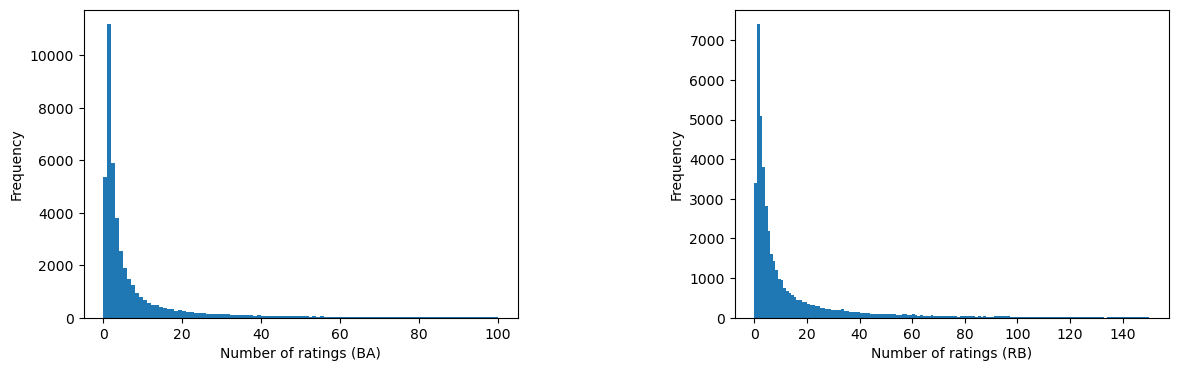

In [13]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(14,4), sharey=False, gridspec_kw={'width_ratios':[1,1], 'wspace': 0.5})

time_MB_beers['nbr_ratings_BA'].sort_values().plot(kind='hist', range = (0, 100), bins= 100, ax=axs[0])
axs[0].set_xlabel('Number of ratings (BA)')
time_MB_beers['nbr_ratings_RB'].sort_values().plot(kind='hist', range = (0, 150), bins= 150, ax=axs[1])
axs[1].set_xlabel('Number of ratings (RB)')

plt.show()

In [14]:
time_MB_beers.nbr_ratings_BA.describe()

count    45640.000000
mean        20.945837
std        137.768038
min          0.000000
25%          1.000000
50%          3.000000
75%          8.000000
max       9228.000000
Name: nbr_ratings_BA, dtype: float64

In [15]:
time_MB_beers.nbr_ratings_RB.describe()

count    45640.000000
mean        22.362796
std         80.107455
min          0.000000
25%          2.000000
50%          5.000000
75%         16.000000
max       5272.000000
Name: nbr_ratings_RB, dtype: float64

Seeing this basic statistics and having observed the histograms we will filter out so that we keep beers with at least 5 ratings for both of the datasets (columns 'nbr_ratings_BA' and 'nbr_ratings_RB'). This will later help us in dimishing the **herding effect** and in assessing popularity by having a consistently high score (and not a high score once).

Fig. 6 in the previously mentioned paper, shows that the herding effect, although never converging to 0, becomes stable with a larger number of ratings with respect to the first one. Thus, we will keep the beers with at least 5 ratings. Note that 5 is the median value of the number of ratings in RateBeer but, in the case of BearAdvocate, it is below it. However, discarding these samples still leaves us with approximately 30% of the data which is a large amount of data (12890 beers).

In [16]:
time_filt_MB_beers = time_MB_beers[(time_MB_beers['nbr_ratings_BA'] >= 5) & (time_MB_beers['nbr_ratings_RB'] >= 5)].copy(deep=True) 

### Macro-averages

In [17]:
# Based on the keep beers (with more than 5 ratings in each source), we will select all the available ratings
beer_id_BA = time_filt_MB_beers.beer_id_BA.to_numpy()
beer_id_RB = time_filt_MB_beers.beer_id_RB.to_numpy()

time_ratings_BA = MB_ratings_BA[MB_ratings_BA['beer_id'].isin(beer_id_BA)].copy(deep=True)
time_ratings_RB = MB_ratings_RB[MB_ratings_RB['beer_id'].isin(beer_id_RB)].copy(deep=True)

In [18]:
# Mean for each beer in each year
avgBA = time_ratings_BA.groupby(['year', 'beer_id'])['detrend'].mean()
avgRB = time_ratings_RB.groupby(['year', 'beer_id'])['detrend'].mean()

In [19]:
# Creation of a dataframe with the results (this also implies matching in the beer ID which is NOT the same for BA and RB)
avgBA_df = avgBA.reset_index()
avgBA_df = avgBA_df.rename(columns={'detrend': 'detrend_BA', 'beer_id': 'beer_id_BA'})
avgRB_df = avgRB.reset_index()
avgRB_df = avgRB_df.rename(columns={'detrend': 'detrend_RB', 'beer_id': 'beer_id_RB'})

matching_RB_id = []
for number in avgBA_df['beer_id_BA']:
    matching_RB_id.append(time_filt_MB_beers.beer_id_RB[time_filt_MB_beers['beer_id_BA']== number].to_numpy()[0])
       
avgBA_df['beer_id_RB'] = matching_RB_id

In [20]:
macro = avgBA_df.merge(avgRB_df, on=['beer_id_RB', 'year'], how='outer')
macro = macro.drop('beer_id_BA', axis=1)

macro['average'] = macro[['detrend_BA', 'detrend_RB']].mean(axis=1)

In [21]:
macro.head()

year  detrend_BA  beer_id_RB  detrend_RB   average
0  1998    0.574938         966         NaN  0.574938
1  1998   -0.882523         529         NaN -0.882523
2  1998   -0.994041         528         NaN -0.994041
3  1998   -0.834351        8735         NaN -0.834351
4  1998   -0.224596        8330         NaN -0.224596

### Top beer each year

In [22]:
result = macro.loc[macro.groupby('year')['average'].idxmax()]

In [23]:
result.head()

year  detrend_BA  beer_id_RB  detrend_RB   average
0      1998    0.574938         966         NaN  0.574938
6      1999   -0.165385        2094         NaN -0.165385
53817  2000         NaN        6075    1.441052  1.441052
53961  2001         NaN        5941    1.695255  1.695255
54431  2002         NaN       16520    1.716757  1.716757

# Geographical analysis

The initial idea was to study the distribution of the data according to the different countries. During the analysis we found out that the data from the United States was also subdivided by state. In order to make the data comparable we transormed the location column of this data to only have the country. However, the distribution of the data was highly skewed so in order to have them balanced, the location column was transformed back to the subdivision by state.

In [24]:
# Copy the dataframe to avoid modifying the variable for further analysis
geo_MB_ratings = MB_ratings.copy()

In [25]:
geo_MB_ratings = hf.correct_time(geo_MB_ratings)
columns_to_keep = ['user_id', 'rating', 'year', 'beer_name','user_id.1']
geo_filter_MB_ratings = geo_MB_ratings.filter(columns_to_keep)

In [26]:
geo_filter_MB_ratings.shape

(21964, 5)

So with the previous datasets we have the geographical location and the brewery name. Furthermore, it can be merged by the userID that coincides in both columns. Since for there are two different user ids (one for each dataset), we will do the merging in just one of them. In our case, we used BA id for the merging.

In [27]:
geo_beers = pd.merge(geo_filter_MB_ratings, MB_users[['user_id','location']], on='user_id', how='inner')

In this way we populate the ratings dataset with the location of each user which provides us a relation between a place and parameters related to the beer.

In [28]:
geo_beers.head()

user_id  rating  year  \
0     erzengel.248045    4.80  2011   
1  visionthing.639993    3.00  2011   
2        tiong.608427    3.85  2012   
3        tiong.608427    3.68  2012   
4        tiong.608427    4.00  2012   

                                       beer_name  user_id.1 location  
0                        Trappistes Rochefort 10      83106  Germany  
1                             Myanmar Lager Beer      91324  Estonia  
2  Cantillon Tyrnilambic Baie D’Argousier Lambic      98624  Finland  
3              Cantillon Pikkulinnun Viskilambic      98624  Finland  
4     Drie Fonteinen Oude Geuze - Armand & Tommy      98624  Finland

In [29]:
location_count = geo_beers.groupby('user_id.1', as_index=False).location.nunique()
nationality_check = location_count.sort_values('location', ascending=False)
nationality_check.head()

user_id.1  location
0           46         1
590     156578         1
579     147944         1
580     147999         1
581     148963         1

In [30]:
count_locations = geo_beers.groupby('location', as_index=False).user_id.count()

In [31]:
popular_locations = count_locations.sort_values(by='user_id', ascending=False)
most_popular_locations = popular_locations[popular_locations.user_id >= 20]

In [32]:
locat_list = most_popular_locations['location'].tolist()

In [33]:
filtered_geo_beers = geo_beers[geo_beers['location'].isin(locat_list)]

In [34]:
filtered_geo_beers.head()

user_id  rating  year  \
0   erzengel.248045    4.80  2011   
7   leighton.343447    4.35  2015   
8   leighton.343447    4.75  2013   
9   leighton.343447    4.00  2016   
10  leighton.343447    4.75  2016   

                                            beer_name  user_id.1 location  
0                             Trappistes Rochefort 10      83106  Germany  
7   Lindemans Oude Gueuze Cuvée René Special Blend...      74136  England  
8                                                 Ann      74136  England  
9                                     Mornin' Delight      74136  England  
10             Beavertown / Boneyard Bloody Notorious      74136  England

In [35]:
def unify_location(loc, keep_state=False):
    if not keep_state:
        return 'United States' if loc.startswith('United States') else loc
    else: 
        if loc.startswith('United States'):
            return loc.split(',')[1]
        else: 
            return loc

In [36]:
filtered_geo_beers['Location'] = filtered_geo_beers.location.apply(unify_location)

In [37]:
filtered_geo_beers['location'] = filtered_geo_beers.location.apply(unify_location, keep_state=True)

In [38]:
#by original location:
count_state_pop = filtered_geo_beers.groupby('location', as_index=False)['user_id.1'].sum()
count_state_pop_order = count_state_pop.sort_values(by='user_id.1', ascending=True)
display(count_state_pop_order)

#by country:
count_country_pop = filtered_geo_beers.groupby('Location', as_index=False)['user_id.1'].sum()
count_country_pop_order = count_country_pop.sort_values(by='user_id.1', ascending=True)
count_country_pop_order

location  user_id.1
20         Nebraska     648286
53         Thailand     868834
18      Mississippi    1414299
19         Missouri    2028897
49         Scotland    2662505
37          Wyoming    3163596
34         Virginia    3521656
29     Rhode Island    3523595
33          Vermont    3615947
26         Oklahoma    3750116
11           Kansas    4006287
50         Slovenia    4913192
1           Arizona    5147452
39          Belarus    5864320
4       Connecticut    6045958
40          Belgium    6185612
38        Australia    6592988
12         Kentucky    6614448
0           Alabama    7886950
10             Iowa    8272744
48           Russia   10405150
9           Indiana   10431168
31        Tennessee   14022240
13        Louisiana   16623521
3          Colorado   17094643
22       New Jersey   18001784
45      Netherlands   22283501
15    Massachusetts   28745681
23         New York   31215969
14         Maryland   32035029
52           Sweden   36963072
41           Brazil   36991517
24   North Carolina   40037183
36        Wisconsin   43275767
32            Texas   45914765
46           Norway   46533887
44          Germany   48044058
25             Ohio   48851672
27           Oregon   55865134
17        Minnesota   59738642
5           Florida   69388927
35       Washington   70233711
2        California   73157782
43          England   73650601
21    New Hampshire   83901189
28     Pennsylvania   92003242
7             Idaho  103565719
8          Illinois  108581291
51            Spain  110921485
30   South Carolina  115467548
6           Georgia  115517115
16         Michigan  145406338
47          Romania  171826916
42           Canada  174270065

Location   user_id.1
15       Thailand      868834
11       Scotland     2662505
12       Slovenia     4913192
1         Belarus     5864320
2         Belgium     6185612
0       Australia     6592988
10         Russia    10405150
7     Netherlands    22283501
14         Sweden    36963072
3          Brazil    36991517
8          Norway    46533887
6         Germany    48044058
5         England    73650601
13          Spain   110921485
9         Romania   171826916
4          Canada   174270065
16  United States  1498716291

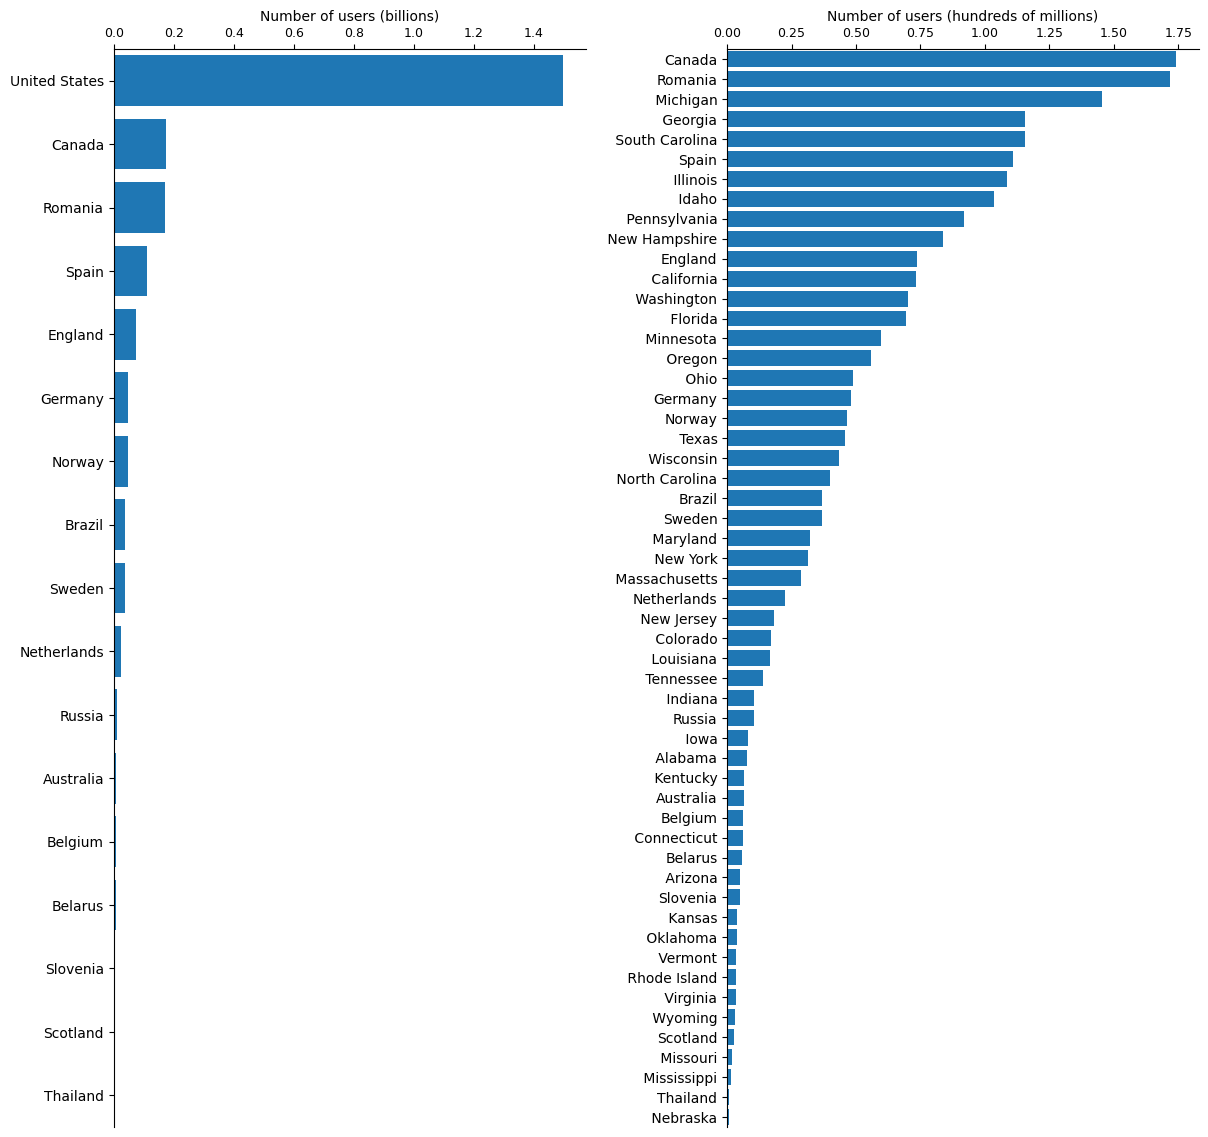

In [39]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(14,14), sharey=False, gridspec_kw={'wspace': 0.3})

axs[0].barh(count_country_pop_order.Location, count_country_pop_order['user_id.1'])
axs[1].barh(count_state_pop_order.location, count_state_pop_order['user_id.1'])
axs[0].tick_params(axis = 'x', labelsize= 9, bottom=False, labelbottom=False, top=True, labeltop=True)
axs[1].tick_params(axis = 'x', labelsize= 9, bottom=False, labelbottom=False, top=True, labeltop=True)
axs[0].xaxis.set_label_position('top')
axs[1].xaxis.set_label_position('top')
axs[0].xaxis.offsetText.set_visible(False)
axs[1].xaxis.offsetText.set_visible(False)


axs[0].spines['bottom'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].spines['right'].set_visible(False)

axs[0].set_ylim(-0.5,len(count_country_pop_order.Location)-0.5)
axs[1].set_ylim(-0.5,len(count_state_pop_order.location)-0.5)
axs[0].set_xlabel('Number of users (billions)')
axs[1].set_xlabel('Number of users (hundreds of millions)')

plt.show()

# Matching users by styles ratings 

As we are focusing on the preferences on the style of beers, we consider that the user that did a review in the two different websites, these are different users

In [40]:
#Merge RB and BA ratings
total_MB_ratings = pd.concat([MB_ratings_BA, MB_ratings_RB])
total_MB_ratings.shape

(1976589, 23)

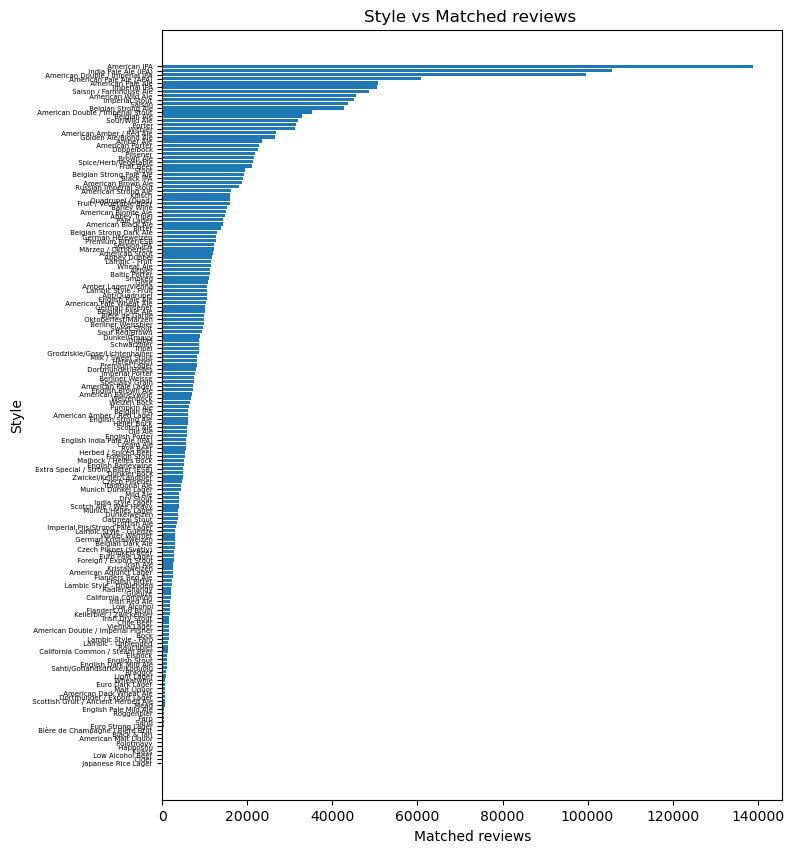

In [41]:
#Here we will see how is the distribution of the different beers

value_counts = total_MB_ratings['style'].value_counts()

fig, ax = plt.subplots( figsize = (8,10))
ax.barh(value_counts.index, value_counts)

# Set labels and title
ax.set_xlabel('Matched reviews')
ax.set_ylabel('Style')
ax.set_title('Style vs Matched reviews ')
ax.tick_params(axis = 'x', labelsize = 10)
ax.tick_params(axis = 'y', labelsize = 5)

# Rotate the entire plot by 90 degrees
plt.gca().invert_yaxis()  # Invert y-axis to make the plot more readable
plt.show()

In [42]:
value_counts[0:10]
#We can see that just in the top 10, there are multiple styles of IPA and Pale Ale that could be somehow grouped

style
 American IPA                      138888
 India Pale Ale (IPA)              105718
 American Double / Imperial IPA     99624
 American Pale Ale (APA)            60756
 American Pale Ale                  50816
 Imperial IPA                       50426
 Saison / Farmhouse Ale             48516
 American Wild Ale                  45615
 Imperial Stout                     44974
 Saison                             43723
Name: count, dtype: int64

In [43]:
style_pref_merged = pd.crosstab(total_MB_ratings['user_id'].values, total_MB_ratings['style'].values, 
                                values = total_MB_ratings['detrend'].values, aggfunc='mean')

style_pref_merged = style_pref_merged.T.fillna(0)

In [44]:
from scipy.stats import pearsonr

#pearson_matrix = style_pref_merged.corr(numeric_only= True)

$$r = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n}(x_i - \bar{x})^2 \sum_{i=1}^{n}(y_i - \bar{y})^2}}$$

With:

 $ r $  the Pearson correlation coefficient
 
 $ n $ the number of data points
 
 $ x_i $ and $y_i$ the individual data points

 $\bar{x}$ and $\bar{y}$ the mean values

Pearson_matrix will give a matrix of size 92113x92113 which is too big, and therefore is computationally complex. For tackling this problem
We thougth on calculating the pearson coefficient per column pairwise and then just keep the maximum value after a defined threshold.

Another idea is to find a better classifier for the styles, either by grouping manually by the type independent of the country and
 subtypes of the style or to apply a ML algorithm for an optimized clustering

# Breweries analysis

In [45]:
# Filter the datasets and remove breweries for which the number of beers associated to them is zero
BA_breweries_filt = BA_breweries[BA_breweries['nbr_beers']>=1].copy(deep=True)
RB_breweries_filt = RB_breweries[RB_breweries['nbr_beers']>=1].copy(deep=True)
MB_breweries_filt = MB_breweries[(MB_breweries['nbr_beers']>=1) & (MB_breweries['nbr_beers.1']>=1)].copy(deep=True)

In [46]:
# Explore properties in each filtered dataset
print('Number of breweries in BA dataset is: {}, and number of unique locations among all breweries is: {}'.format(BA_breweries_filt.shape[0], BA_breweries_filt.location.nunique()))
print('Number of breweries in RB dataset is: {}, and number of unique locations among all breweries is: {}'.format(RB_breweries_filt.shape[0], RB_breweries_filt.location.nunique()))
print('Number of breweries in MB dataset is: {}, and number of unique locations among all breweries is: {}'.format(MB_breweries_filt.shape[0], MB_breweries_filt.location.nunique()))

Number of breweries in BA dataset is: 14522, and number of unique locations among all breweries is: 277
Number of breweries in RB dataset is: 24118, and number of unique locations among all breweries is: 267
Number of breweries in MB dataset is: 7600, and number of unique locations among all breweries is: 202


The two previous chuncks of code shows that the MB dataset has a lower number of breweries compared to the BA and RB datasets. If we want to provide information on as many breweries as possible, we will need to compute the union between the BA and RB datasets. This could be done on the brewery names, adjusting for changes in the naming.

In [47]:
MB_breweries.head()

id          location                                  name  nbr_beers  \
0  10093  Northern Ireland  Strangford Lough Brewing Company Ltd          5   
1  32848  Northern Ireland                   The Sheelin Brewery          4   
2  40360  Northern Ireland           Walled City Brewing Company          6   
3  40309  Northern Ireland                  Ards Brewing Company          7   
4  41205  Northern Ireland                   Barrahooley Brewery          3   

    id.1        location.1                     name.1  nbr_beers.1      diff  \
0   4959  Northern Ireland           Strangford Lough            5  0.431275   
1  17616  Northern Ireland                    Sheelin            2  0.526388   
2  24866  Northern Ireland                Walled City            3  0.527852   
3  13538  Northern Ireland           Ards Brewing Co.           13  0.554395   
4  22304  Northern Ireland  Barrahooley Craft Brewery            4  0.602544   

        sim  
0  0.889062  
1  0.863596  
2  0.954183  
3  0.896098  
4  0.896205

On the MB dataset one can observe that the nbr_beer differs sometimes between the RB and BA datasets. For breweries present in both datasets and having different number of beers associated with them, we will consider the higher number. 

In [48]:
BA_breweries_filt['nbr_beers'].describe()

count    14522.000000
mean        24.298444
std         74.041044
min          1.000000
25%          3.000000
50%          8.000000
75%         21.000000
max       1196.000000
Name: nbr_beers, dtype: float64

In [49]:
RB_breweries_filt['nbr_beers'].describe()

count    24118.000000
mean        19.078655
std         31.572100
min          1.000000
25%          3.000000
50%          8.000000
75%         20.000000
max        295.000000
Name: nbr_beers, dtype: float64

The previous two chuncks of code show that the mean values are higher than the median in both datasets, indicating that the distribution of number of beers in breweries is highly skewed. 

In [50]:
print('Number of unique locations in the BA dataset if we select breweries that produce maximum 8 types of beers is: {}'. format(BA_breweries_filt[(BA_breweries_filt['nbr_beers']<=8)].location.nunique()))
print('Number of unique locations in the RB dataset if we select breweries that produce maximum 8 types of beers is: {}'. format(RB_breweries_filt[(RB_breweries_filt['nbr_beers']<=8)].location.nunique()))

Number of unique locations in the BA dataset if we select breweries that produce maximum 8 types of beers is: 260
Number of unique locations in the RB dataset if we select breweries that produce maximum 8 types of beers is: 259


We can see that if we perform a hard filtering on both dataset, by selecting breweries that produce a maximum of 8 types of beer, then we will recover almost all locations present in both datasets.
Our goal is to select breweries with the 'local' connotation. Our intepretation here is that in industrial breweries, meaning breweries producing a large number of beers (for instance more than 100), the beers are probably accessible to broad market that could even include a set of countries. While breweries that have a small number of beers associated to them, could probably be more 'local' and only know within a country. 
In this analysis, we will make the assumption that the number of beers associated with a brewery correspond to the real number of beers produced by that brewery

In [51]:
BA_breweries_subst = BA_breweries_filt[BA_breweries_filt['nbr_beers'] <= 8].copy(deep=True)
RB_breweries_subst = RB_breweries_filt[RB_breweries_filt['nbr_beers'] <= 8].copy(deep=True)

In [52]:
# Filtering beers datasets for beers belonging to the microbreweries (breweries producing max 8 beers) subset before
BA_craft_beers = BA_beers[BA_beers['brewery_id'].isin(BA_breweries_subst['id'].to_list())]
RB_craft_beers = RB_beers[RB_beers['brewery_id'].isin(RB_breweries_subst['id'].to_list())]

# Text analysis

The rationale behind this section is to process the textual reviews given by the users in order to provide insight about:
- Clustering (section II of methods) of users to see if similar wording are used by users
- Fun facts (section III of methods) about the community to see if there is:
    - Decreasing length of the reviews over the years
    - Unusual words used when describing reviews with high ABV beers

We will start by selecting only english reviews (for reasons described) and pre-processing the reviews by using a python script. The next steps include the calculation of length and TF-IDF scores for each review. For the clustering task, from the TF-IDF we will extrapolate words that best define each reviewers. For the fun facts section, we will use TF-IDF to identify unusual words and use SVD decomposition to reduce dimensionality of the reviews and represent them into vectorial space. By color coding each review by corresponding ABV content we can see if there's any relation between the ABV and the unusual words used by reviewers.

\begin{equation*}
 \text{TF}(t, d) = \frac{count(t)}{count(g)} \qquad\qquad \text{IDF}(t) = \log{\frac{1+n}{1+df(t)}} + 1
\end{equation*}


\begin{equation*}
 \text{TF-IDF}(t,d) = \text{TF}(t, d) * \text{IDF}(t)
\end{equation*}

where:
- $t$ is the specific term in a document
- $g$ is the general token in a specific document
- $n$ is the total number of documents in the set
- $df(t)$ is the number of document term $t$ is present in


In [53]:
# Concatenating all informations for the text analysis
df_txt_analysis = pd.concat([MB_ratings_RB.copy(), MB_ratings_BA.copy()], ignore_index=True)

# Keeping only potentially informative columns for textual analysis and dropping missing values
df_txt_analysis = df_txt_analysis[['abv', 'beer_name', 'brewery_name', 'style', 'year', 'rating', 'user_name', 'detrend', 'text']]
df_txt_analysis.dropna(subset='text', inplace=True)
df_txt_analysis.head()

abv         beer_name            brewery_name        style  year  rating  \
0  8.0   Abita Andygator   Abita Brewing Company   Doppelbock  2000     3.5   
1  8.0   Abita Andygator   Abita Brewing Company   Doppelbock  2002     2.6   
2  8.0   Abita Andygator   Abita Brewing Company   Doppelbock  2002     2.2   
3  8.0   Abita Andygator   Abita Brewing Company   Doppelbock  2002     2.8   
4  8.0   Abita Andygator   Abita Brewing Company   Doppelbock  2002     3.0   

       user_name   detrend                                               text  
0     DJH-Bird99  0.078186   Good beer, espacially when you put on DJ Alig...  
1   pauliefrog99 -0.668204   A little bit of caramel and malt flavor in th...  
2    daviddeep99 -1.086552   I think this beer is made by thinning one par...  
3         wodom1 -0.458480   This beer is actually 11.5%.  3 or 4 of them ...  
4     JohnDo2000 -0.248976   The beer is good, but it sure will knock you ...

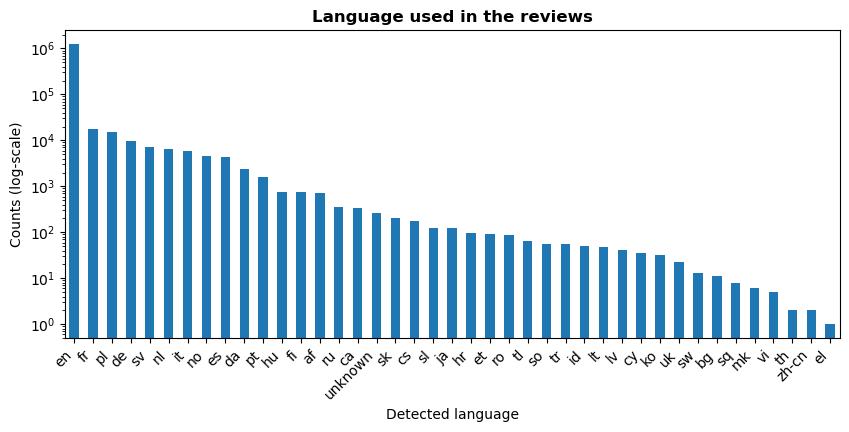

In [54]:
# The following cell (1/2) takes a long time to run. In case of need, we provide the tsv document generate at the following link:
# https://drive.google.com/drive/folders/17qaRlCumz7pfNYN_Wi0tANMIOS0jOUoB?usp=sharing
# It must be located in the MB_path folder

# Assigning language to the text analysis dataset 
df_txt_analysis = txt_pproc.adding_language(df_txt_analysis, MB_path)

# Plotting the language distributions for the text analysis dataset 
fig, ax = plt.subplots(figsize=(10,4))

language_counts = df_txt_analysis['language'].value_counts()
language_counts.plot(kind='bar')
plt.title('Language used in the reviews', weight='bold')
plt.xlabel('Detected language')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Counts (log-scale)')
plt.yscale('log')

plt.show()

Considering the distributions of languages detected we will filter the dataset only based on the English reviews. The reason of this choice comes from the need to find tune the parameters for each language during text pre-processing. Since English is the most common language among the reviews with 2 higher order of magnitude int counts we will only use English in the analysis.

In [55]:
# Keeping only english reviews
df_txt_analysis_en = df_txt_analysis[df_txt_analysis.language == 'en']
df_txt_analysis_en.head()

abv         beer_name            brewery_name        style  year  rating  \
0  8.0   Abita Andygator   Abita Brewing Company   Doppelbock  2000     3.5   
1  8.0   Abita Andygator   Abita Brewing Company   Doppelbock  2002     2.6   
2  8.0   Abita Andygator   Abita Brewing Company   Doppelbock  2002     2.2   
3  8.0   Abita Andygator   Abita Brewing Company   Doppelbock  2002     2.8   
4  8.0   Abita Andygator   Abita Brewing Company   Doppelbock  2002     3.0   

       user_name   detrend                                               text  \
0     DJH-Bird99  0.078186   Good beer, espacially when you put on DJ Alig...   
1   pauliefrog99 -0.668204   A little bit of caramel and malt flavor in th...   
2    daviddeep99 -1.086552   I think this beer is made by thinning one par...   
3         wodom1 -0.458480   This beer is actually 11.5%.  3 or 4 of them ...   
4     JohnDo2000 -0.248976   The beer is good, but it sure will knock you ...   

  language  
0       en  
1       en  
2       en  
3       en  
4       en

In [56]:
# The following cell (1/2) takes a long time to run. In case of need, we provide the tsv document generate at the following link:
# https://drive.google.com/drive/folders/17qaRlCumz7pfNYN_Wi0tANMIOS0jOUoB?usp=sharing
# It must be located in the MB_path folder

# Text preprocessing and dropping nan values that can arise from the processing
df_txt_processed = txt_pproc.cleaning(df_txt_analysis_en, MB_path)
df_txt_processed.dropna(subset=['text'], inplace=True)
df_txt_processed.head()

abv         beer_name            brewery_name        style  year  rating  \
0  8.0   Abita Andygator   Abita Brewing Company   Doppelbock  2000     3.5   
1  8.0   Abita Andygator   Abita Brewing Company   Doppelbock  2002     2.6   
2  8.0   Abita Andygator   Abita Brewing Company   Doppelbock  2002     2.2   
3  8.0   Abita Andygator   Abita Brewing Company   Doppelbock  2002     2.8   
4  8.0   Abita Andygator   Abita Brewing Company   Doppelbock  2002     3.0   

       user_name   detrend                                               text  \
0     DJH-Bird99  0.078186  good beer espacially put dj aligator whistle song   
1   pauliefrog99 -0.668204       little bit caramel malt flavor way thin weak   
2    daviddeep99 -1.086552  think beer make thin one part anchor foghorn t...   
3         wodom1 -0.458480  beer actually        get hammer good beer look...   
4     JohnDo2000 -0.248976  beer good sure knock ass tell bartender eight ...   

  language                                      tokenize_text  
0       en  ['good', 'beer', 'espacially', 'put', 'dj', 'a...  
1       en  ['little', 'bit', 'caramel', 'malt', 'flavor',...  
2       en  ['think', 'beer', 'make', 'thin', 'one', 'part...  
3       en  ['beer', 'actually', 'get', 'hammer', 'good', ...  
4       en  ['beer', 'good', 'sure', 'knock', 'ass', 'tell...

In [57]:
# Adding length of each review to the dataset
df_txt_processed['len'] = df_txt_processed['tokenize_text'].apply(lambda text: len(text))
df_txt_processed.head()

abv         beer_name            brewery_name        style  year  rating  \
0  8.0   Abita Andygator   Abita Brewing Company   Doppelbock  2000     3.5   
1  8.0   Abita Andygator   Abita Brewing Company   Doppelbock  2002     2.6   
2  8.0   Abita Andygator   Abita Brewing Company   Doppelbock  2002     2.2   
3  8.0   Abita Andygator   Abita Brewing Company   Doppelbock  2002     2.8   
4  8.0   Abita Andygator   Abita Brewing Company   Doppelbock  2002     3.0   

       user_name   detrend                                               text  \
0     DJH-Bird99  0.078186  good beer espacially put dj aligator whistle song   
1   pauliefrog99 -0.668204       little bit caramel malt flavor way thin weak   
2    daviddeep99 -1.086552  think beer make thin one part anchor foghorn t...   
3         wodom1 -0.458480  beer actually        get hammer good beer look...   
4     JohnDo2000 -0.248976  beer good sure knock ass tell bartender eight ...   

  language                                      tokenize_text  len  
0       en  ['good', 'beer', 'espacially', 'put', 'dj', 'a...   74  
1       en  ['little', 'bit', 'caramel', 'malt', 'flavor',...   69  
2       en  ['think', 'beer', 'make', 'thin', 'one', 'part...  155  
3       en  ['beer', 'actually', 'get', 'hammer', 'good', ...  272  
4       en  ['beer', 'good', 'sure', 'knock', 'ass', 'tell...  369

In [58]:
# Computing TF-IDF matrix

tfidf_vec = TfidfVectorizer()
tfidf_mat = tfidf_vec.fit_transform(df_txt_processed['text'])

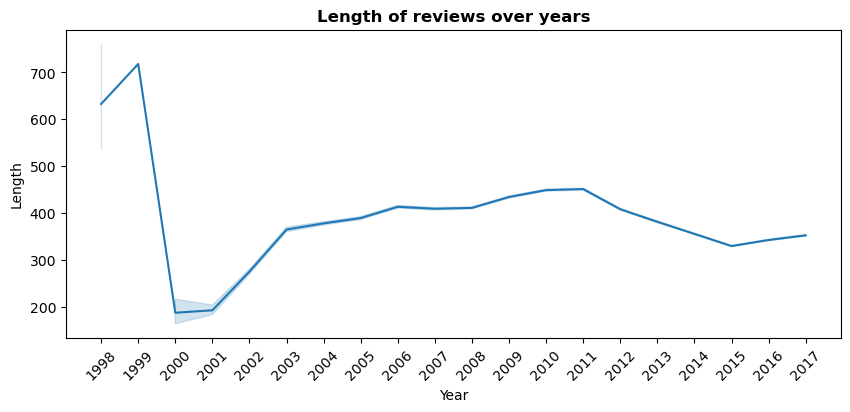

In [59]:
# Plotting the length of the reviews over years
fig, ax = plt.subplots(figsize=(10,4))

sns.lineplot(df_txt_processed, x='year', y='len')
plt.title('Length of reviews over years', weight='bold')
plt.xlabel('Year')
plt.xticks(np.unique(df_txt_processed.year), rotation=45)
plt.ylabel('Length')

plt.show()

Our hypothesis was that the lenght of reviews would decreased over year as we're living in a fast-paced world. We can observe this phenomenon in the decreased length of songs and possibility to speed up audio messages. Also the beer reviews seem to decrease in lenght over the years. However, this effect is only visible from 1998 to 2001 and then there's an increase with stable values. To further test our hypothesis (confirm or refuse) we have to look more into the data to disentagle other features (such as reviewer)  that could effect length of reviews.

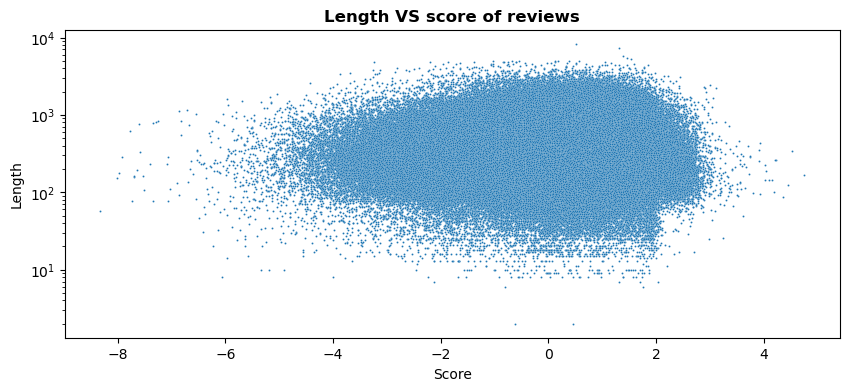

In [60]:
# Plotting the length and score of the reviews
fig, ax = plt.subplots(figsize=(10,4))

sns.scatterplot(data=df_txt_processed, x='detrend', y='len', s=2)
plt.title('Length VS score of reviews', weight='bold')
plt.xlabel('Score')
plt.ylabel('Length')
plt.yscale('log')

plt.show()

One of our hypothesis was that people that have bad experiences with beers would tend to write longer reviews to be more critic. Nevertheless, the just mentioned trend does not seem to appear as length and score seem not to be correlated